In [1]:
from google.colab import drive
drive.mount('/content/drive')

import random
import sys
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/MIE_atlas/')
sys.path.append('/content/drive/MyDrive/Chemistry_PhD/interpretability/models/')

import os

!pip install shap
!pip install rdkit-pypi -qqq
!pip install xgboost
!pip install torchbnn


# custom import from MIE_atlas library
from featurizers.molfeaturizer import MorganFPFeaturizer
# custom bnn classifier wrapper
from bnnclass import BNNClassifier

import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

import shap
from shap import TreeExplainer, KernelExplainer, DeepExplainer

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps

import matplotlib.pyplot as plt

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 34.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Data setup

data_path = '/content/drive/MyDrive/Chemistry_PhD/interpretability/data/'

all_data = pd.read_csv(data_path + 'combined_cleaned_data.csv') # 8403 mols, 4265 positive
helma_data = pd.read_csv(data_path + 'helma_cleaned_data.csv')
martinez_data = pd.read_csv(data_path + 'martinez_cleaned_data.csv')
xu_data = pd.read_csv(data_path + 'xu_cleaned_data.csv')

screened = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/all_data_screened.csv')
atom_labels = screened['A_Labels']

helma_train = helma_data # 7369 mols, 3664 positive
helma_test = pd.concat([helma_data, all_data]).drop_duplicates(keep=False) # 1308 mols, 753 positive

martinez_train = martinez_data # 5194 mols, 3015 positive
martinez_test = pd.concat([martinez_data, all_data]).drop_duplicates(keep=False) # 3669 mols, 1346 positive

xu_train = xu_data # 6765 mols, 3668 positive
xu_test = pd.concat([xu_data, all_data]).drop_duplicates(keep=False) # 1848 mols, 663 positive


# set seed for experiments later

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    return

[12:03:49] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:51] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not removing hydrogen atom without neighbors
[12:03:52] WARNING: not r

run with seed: 0
bal acc: 0.8202378421283893
mcc: 0.640325946578686


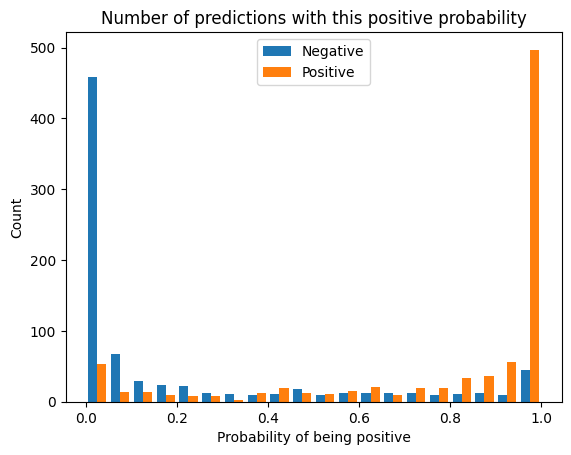

<Figure size 640x480 with 0 Axes>

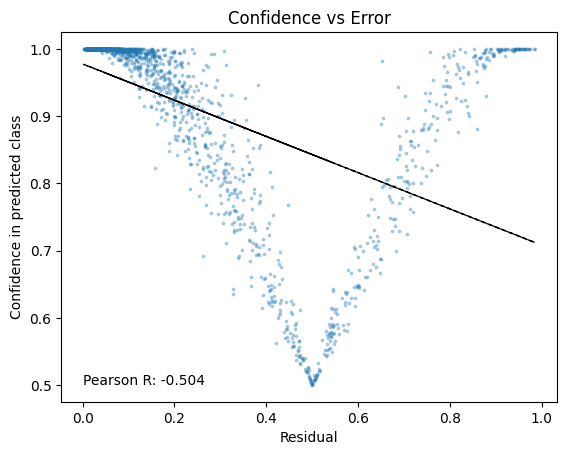

<Figure size 640x480 with 0 Axes>

In [ ]:
# All data


smiles = all_data['SMILES']
y = all_data['Label'].values
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)

X = featurizer.transform(smiles)

indices = np.arange(len(X))

# in this experiment, train_test_split should not be affected by the seed to avoid this becoming a bootstrap (it's only a replicate to ensure the model works in general)
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, indices, test_size = 0.2, random_state = 0)

seeds = [0]
#seeds = [0, 27, 23, 2, 4]

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model_all = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model_all.set_hparams(kl_weight = 1, lr = 0.003)
    model_all.fit(X_in, y_in)

    model_all.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model_all.predict_normal_distribution(X_test, resample = False)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print('bal acc:', balanced_accuracy_score(y_test, y_pred))
    print('mcc:', matthews_corrcoef(y_test, y_pred))


    n_bins = 20
    y_proba = np.array(model_all.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/all_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model_all.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/all_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()



[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:26] WARNING: not removing hydrogen atom without neighbors
[12:07:27] WARNING: not removing hydrogen atom without neighbors
[12:07:27] WARNING: not r

run with seed: 0
0.7229280027492984
0.4444102783195737


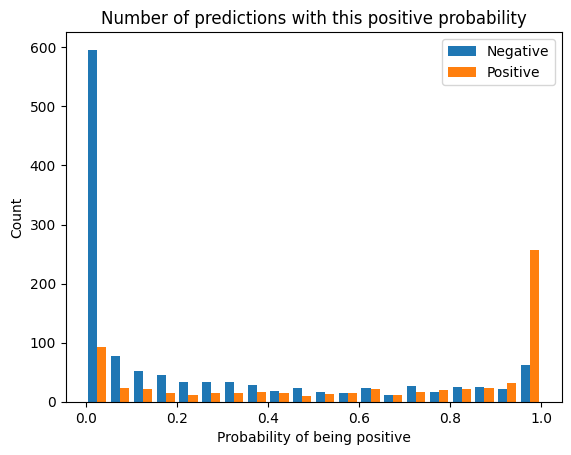

<Figure size 640x480 with 0 Axes>

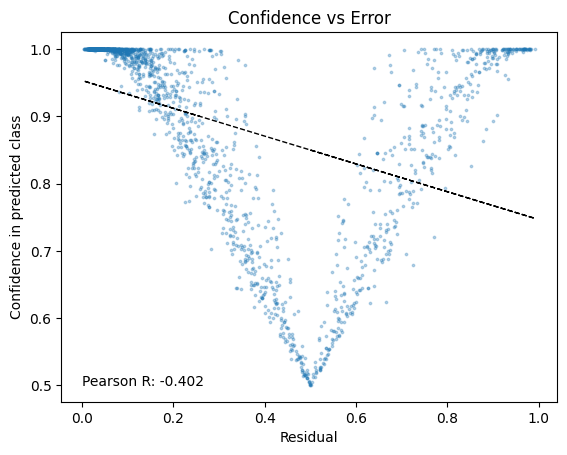

<Figure size 640x480 with 0 Axes>

In [ ]:
# Xu dataset

smiles_train = xu_train['SMILES']
smiles_test = xu_test['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)


X_train = featurizer.transform(smiles_train)
y_train = xu_train['Label'].values
X_test = featurizer.transform(smiles_test)
y_test = xu_test['Label'].values

seeds = [0]
#seeds = [0, 27, 23, 2, 4]

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model_xu = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model_xu.set_hparams(kl_weight = 1, lr = 0.003)
    model_xu.fit(X_in, y_in)

    model_xu.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model_xu.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    n_bins = 20
    y_proba = np.array(model_xu.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/xu_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model_xu.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/xu_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()

[12:10:05] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:06] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not removing hydrogen atom without neighbors
[12:10:07] WARNING: not r

run with seed: 0
0.7113192002706956
0.40856171090832705


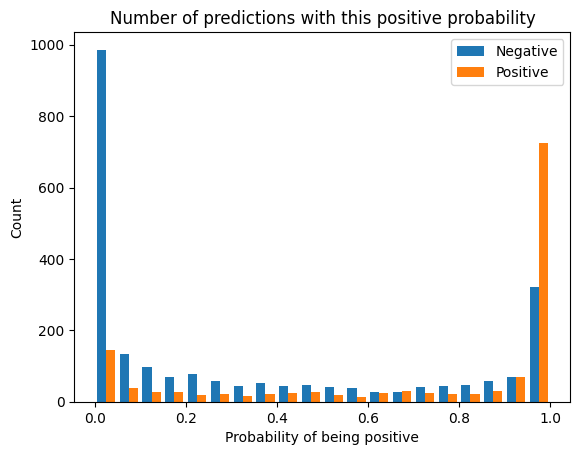

<Figure size 640x480 with 0 Axes>

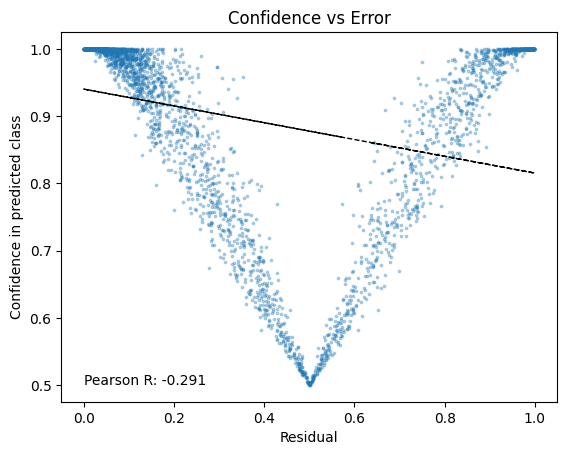

<Figure size 640x480 with 0 Axes>

In [ ]:
# Martinez dataset


smiles_train = martinez_train['SMILES']
smiles_test = martinez_test['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)


X_train = featurizer.transform(smiles_train)
y_train = martinez_train['Label'].values
X_test = featurizer.transform(smiles_test)
y_test = martinez_test['Label'].values

seeds = [0]
#seeds = [0, 27, 23, 2, 4]

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model_martinez = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model_martinez.set_hparams(kl_weight = 1, lr = 0.003)
    model_martinez.fit(X_in, y_in)

    model_martinez.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model_martinez.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    n_bins = 20
    y_proba = np.array(model_martinez.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/martinez_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model_martinez.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/martinez_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()

[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:44] WARNING: not removing hydrogen atom without neighbors
[12:14:45] WARNING: not r

run with seed: 0
0.7316715121495998
0.45994328247491134


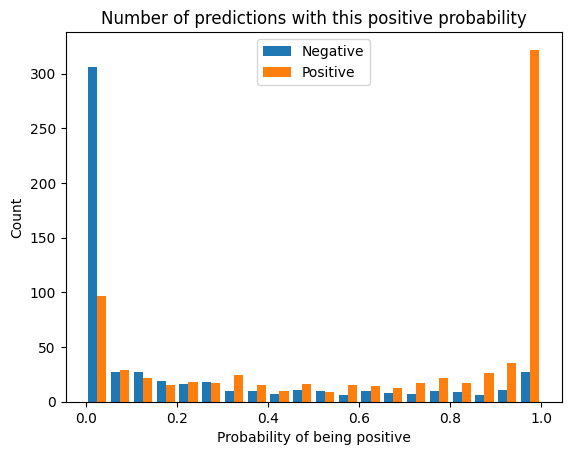

<Figure size 640x480 with 0 Axes>

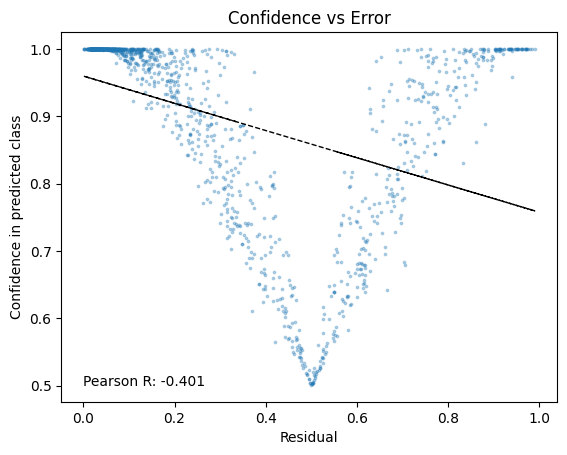

<Figure size 640x480 with 0 Axes>

In [ ]:
# Helma dataset


smiles_train = helma_train['SMILES']
smiles_test = helma_test['SMILES']
featurizer = MorganFPFeaturizer(nBits=8000, radius=2)


X_train = featurizer.transform(smiles_train)
y_train = helma_train['Label'].values
X_test = featurizer.transform(smiles_test)
y_test = helma_test['Label'].values

seeds = [0]
#seeds = [0, 27, 23, 2, 4]

for seed in seeds:
    set_seed(seed)

    X_train, y_train = shuffle(X_train, y_train, random_state = seed)

    model_helma = BNNClassifier(
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 8000, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 10),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.03, in_features = 10, out_features = 2)
    )


    # convert format of X and y to Tensor objects
    X_in = torch.from_numpy(X_train).float() # need same dtype as weight matrix
    y_in = torch.from_numpy(y_train).long()

    model_helma.set_hparams(kl_weight = 1, lr = 0.003)
    model_helma.fit(X_in, y_in)

    model_helma.sample_posterior(X_test, n_samples = 5000)
    y_mu, y_sigma = model_helma.predict_normal_distribution(X_test, resample = False, n_samples = 5000)

    y_pred = [int(x>0) for x in y_mu]
    print('run with seed:', seed)
    print(balanced_accuracy_score(y_test, y_pred))
    print(matthews_corrcoef(y_test, y_pred))

    n_bins = 20
    y_proba = np.array(model_helma.predict_proba(X_test, resample = False))
    positives = y_proba[np.where(y_test==1)]
    negatives = y_proba[np.where(y_test==0)]
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.hist([negatives, positives], n_bins)
    ax.set_title("Number of predictions with this positive probability")
    ax.set_xlabel("Probability of being positive")
    ax.set_ylabel("Count")
    ax.legend(['Negative', 'Positive'])
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/helma_data/{seed}_prob.png')
    plt.show()
    plt.clf()


    y_softmax = np.array(model_helma.predict_softmax_proba(X_test, resample = False))
    confidence = np.array([max(x, 1-x) for x in y_proba])
    error = np.array([np.abs(y_test[x] - y_softmax[x]) for x in range(len(X_test))])
    gradient, intercept = np.polyfit(error, confidence, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.scatter(error, confidence, s = 3, alpha = 0.3)
    ax.plot(error, error*gradient + intercept, color = 'k', ls = 'dashed', lw = 1)
    ax.set_title("Confidence vs Error")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Confidence in predicted class")
    ax.text(0, 0.5, f'Pearson R: {np.around(st.pearsonr(error, confidence)[0],3)}')
    #plt.savefig(f'/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/uncertainty/helma_data/{seed}_confidence_vs_error.png')
    plt.show()
    plt.clf()

In [ ]:
models = [model_all, model_xu, model_martinez, model_helma]
for model in models:
    print(model.predict_proba(X[7851].reshape(1,-1)))

[0.9999999996394773]
[0.9999885084506286]
[0.9999999999943069]
[0.9999561081363711]


In [3]:
# want to find where the SA are in each molecule

dna_alerts = pd.read_csv('/content/drive/MyDrive/Chemistry_PhD/interpretability/tests/interpretability/DNA_binding_alerts.csv')

names = dna_alerts['Structural Alert'].values
smarts = dna_alerts['SMARTS'].values
smiles = all_data['SMILES']
labels = all_data['Label']
assert(len(names) == len(smarts))

a_labels = []
alerts = [Chem.MolFromSmarts(x) for x in smarts]

'''
for i in range(len(smiles)):
    has_sa = screened['SA'][i]
    if has_sa:
        mol = Chem.MolFromSmiles(smiles[i])
        matches = np.unique([x for alert in alerts for found in mol.GetSubstructMatches(alert) for x in found])
        a_matches = [0] * mol.GetNumAtoms()
        for x in matches:
            a_matches[int(x)] = 1
        a_labels.append(a_matches)
    else:
        a_labels.append([])

screened['A_Labels'] = a_labels
'''

"\nfor i in range(len(smiles)):\n    has_sa = screened['SA'][i]\n    if has_sa:\n        mol = Chem.MolFromSmiles(smiles[i])\n        matches = np.unique([x for alert in alerts for found in mol.GetSubstructMatches(alert) for x in found])\n        a_matches = [0] * mol.GetNumAtoms()\n        for x in matches:\n            a_matches[int(x)] = 1\n        a_labels.append(a_matches)\n    else:\n        a_labels.append([])\n\nscreened['A_Labels'] = a_labels\n"

In [30]:
testsmarts = '[$(c[N+](=O)[O-]);r5]'
testmol = Chem.MolFromSmiles('CCC(C)OC(=O)C=Cc1ccc([N+](=O)[O-])o1')
testfrag = Chem.MolFromSmarts(testsmarts)
for atom in testmol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))


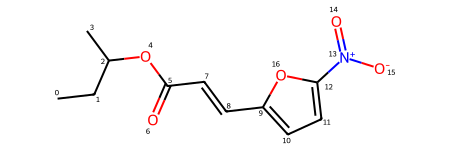

In [31]:
testmol

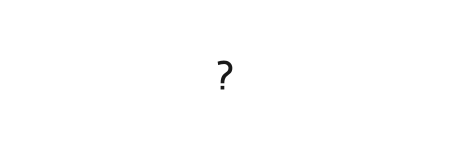

In [32]:
testfrag

In [33]:
testfrag.GetNumAtoms()

1

In [27]:
testmol.GetSubstructMatches(testfrag)

((12,),)

In [34]:
print(rdkit.__version__)

2022.09.5


In [37]:
testfrag.GetAtomWithIdx(0).GetSmarts()

'[$(c[N&+](=O)[O&-])&r5]'

In [38]:
testfrag.GetAtomWithIdx(0).GetNeighbors()

()